In [ ]:
import os
import joblib
import pandas as pd
import kagglehub
import transformers
import torch
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
)
from IPython.display import Markdown, display

# 1. Dataset Preparation


In [2]:
path = kagglehub.dataset_download(
    "suchintikasarkar/sentiment-analysis-for-mental-health"
)
print("Path to dataset files:", path)

Path to dataset files: /home/cici/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1


In [3]:
df = pd.read_csv(path + "/Combined Data.csv")
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [5]:
df = df.dropna()

In [6]:
dups = df.duplicated(subset=["statement"]).sum()
print(f"Total duplicate statements in entire dataset: {dups}")

dups_per_status = (
    df[df.duplicated(subset=["statement"], keep=False)].groupby("status").size()
)
print("\nDuplicates found per status:")
print(dups_per_status)

df = df.drop_duplicates(subset=["statement"], keep="first").copy()

Total duplicate statements in entire dataset: 1608

Duplicates found per status:
status
Anxiety                 433
Bipolar                 552
Depression              601
Normal                  463
Personality disorder    362
Stress                  574
Suicidal                 26
dtype: int64


In [7]:
drop = ["Anxiety", "Stress", "Bipolar", "Personality disorder"]

df = df[~df["status"].isin(drop)].copy()
df = df.reset_index(drop=True)

# 2. BERT Model Training and Evaluation


In [8]:
SEED = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.1
MODEL_DIR = "models"

In [9]:
torch.manual_seed(SEED)
os.makedirs(MODEL_DIR, exist_ok=True)

In [10]:
X = df["statement"]
y = df["status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=VAL_SIZE / (1 - TEST_SIZE),
    random_state=SEED,
    stratify=y_train,
)

In [11]:
class BertSA:
    def __init__(self, model_name="bert-base-cased", num_labels=3):
        self.device = (
            torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        )

        # model and tokenizer
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=num_labels
        ).to(self.device)

        # label mappings (populated during fit)
        self.label2id = {}
        self.id2label = {}

        # training parameters
        self.lr = 5e-5
        self.weight_decay = 1e-4
        self.train_batch_size = 32
        self.grad_accum_steps = 1
        self.num_epochs = 5

        # inference parameters
        self.pred_batch_size = 32

    def encode(self, batch_texts, batch_labels=None):
        enc = self.tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            return_tensors="pt",
        )

        if batch_labels is not None:
            labels = [self.label2id[label] for label in batch_labels]
            enc["labels"] = torch.tensor(labels, dtype=torch.long)

        return enc

    def fit(self, X_train, y_train, X_val, y_val):
        N = len(X_train)
        # build label mapping from training data
        for label in sorted(set(y_train)):
            if label not in self.label2id:
                idx = len(self.label2id)
                self.label2id[label] = idx
                self.id2label[idx] = label

        # attach mappings to model config
        self.model.config.label2id = dict(self.label2id)
        self.model.config.id2label = dict(self.id2label)

        opt = torch.optim.AdamW(
            self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay
        )

        sch = torch.optim.lr_scheduler.CosineAnnealingLR(
            opt, T_max=self.num_epochs, eta_min=self.lr * 0.1
        )

        best_val_acc = 0
        best_model_wts = None

        for epoch in range(self.num_epochs):
            print(f"Epoch {epoch + 1}/{self.num_epochs}: LR={sch.get_last_lr()[0]:.6f}")

            total_loss = 0.0
            num_batches = 0
            indices = torch.randperm(N)

            self.model.train()
            opt.zero_grad(set_to_none=True)
            for start in tqdm.tqdm(range(0, N, self.train_batch_size)):
                num_batches += 1
                batch_indices = indices[start : start + self.train_batch_size].tolist()
                batch_texts = X_train.iloc[batch_indices].tolist()
                batch_labels = y_train.iloc[batch_indices].tolist()

                enc = self.encode(batch_texts, batch_labels)
                enc = {k: v.to(self.device, non_blocking=True) for k, v in enc.items()}

                outputs = self.model(**enc)
                loss = outputs.loss
                total_loss += loss.item()
                loss /= self.grad_accum_steps
                loss.backward()

                if (num_batches % self.grad_accum_steps) == 0 or (
                    start + self.train_batch_size >= N
                ):
                    opt.step()
                    opt.zero_grad(set_to_none=True)

            sch.step()
            avg_loss = total_loss / max(1, num_batches)
            y_pred = self.predict(X_val)
            val_acc = accuracy_score(y_val, y_pred)
            print(f"  Average training loss: {avg_loss:.4f}")
            print(f"  Validation set accuracy: {val_acc:.4f}")
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_wts = {
                    k: v.cpu().clone() for k, v in self.model.state_dict().items()
                }
                print(f"  -> New best model found! Saved (Acc: {best_val_acc:.4f})")

        if best_model_wts is not None:
            print(
                f"Training complete. Loading best model with accuracy: {best_val_acc:.4f}"
            )
            self.model.load_state_dict(best_model_wts)
        else:
            print("Training complete. No improvement found.")

    def predict(self, X):
        if not self.id2label:
            raise ValueError("Label mapping is empty. Call fit() before predict().")

        self.model.eval()
        preds = []

        for start in tqdm.tqdm(range(0, len(X), self.pred_batch_size)):
            batch_texts = X.iloc[start : start + self.pred_batch_size].tolist()
            enc = self.encode(batch_texts)
            enc = {k: v.to(self.device) for k, v in enc.items()}

            with torch.inference_mode():
                outputs = self.model(**enc)
                logits = outputs.logits
                batch_preds = torch.argmax(logits, dim=-1).cpu().tolist()
                batch_labels = [self.id2label[pred] for pred in batch_preds]
                preds.extend(batch_labels)

        return preds

In [12]:
# Train + evaluate (quick end-to-end check)
num_labels = y_train.nunique()
model_path = os.path.join(MODEL_DIR, "bert_sa_model.pkl")
is_trained = False
if os.path.exists(model_path):
    sa: BertSA = joblib.load(model_path)
    is_trained = True
else:
    sa = BertSA(model_name="bert-base-cased", num_labels=int(num_labels))

In [ ]:
if not is_trained:
    sa.fit(X_train, y_train, X_val, y_val)
    joblib.dump(sa, model_path)

Epoch 1/5: LR=0.000050


100%|██████████| 131/131 [01:03<00:00,  2.06it/s]


  Average training loss: 0.3947
  Validation set accuracy: 0.8532
  -> New best model found! Saved (Acc: 0.8532)
Epoch 2/5: LR=0.000046


100%|██████████| 131/131 [01:03<00:00,  2.07it/s]


  Average training loss: 0.2823
  Validation set accuracy: 0.8604
  -> New best model found! Saved (Acc: 0.8604)
Epoch 3/5: LR=0.000034


100%|██████████| 131/131 [01:03<00:00,  2.06it/s]


  Average training loss: 0.2012
  Validation set accuracy: 0.8568
Epoch 4/5: LR=0.000021


100%|██████████| 131/131 [01:03<00:00,  2.05it/s]


  Average training loss: 0.1113
  Validation set accuracy: 0.8497
Epoch 5/5: LR=0.000009


100%|██████████| 131/131 [01:03<00:00,  2.05it/s]


  Average training loss: 0.0462
  Validation set accuracy: 0.8513
Training complete. Loading best model with accuracy: 0.8604


In [13]:
sa.pred_batch_size = 4
y_pred = sa.predict(X_test)

100%|██████████| 2089/2089 [02:05<00:00, 16.64it/s]


In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Depression       0.80      0.83      0.82      3018
      Normal       0.97      0.99      0.98      3208
    Suicidal       0.77      0.70      0.73      2128

    accuracy                           0.86      8354
   macro avg       0.84      0.84      0.84      8354
weighted avg       0.86      0.86      0.86      8354



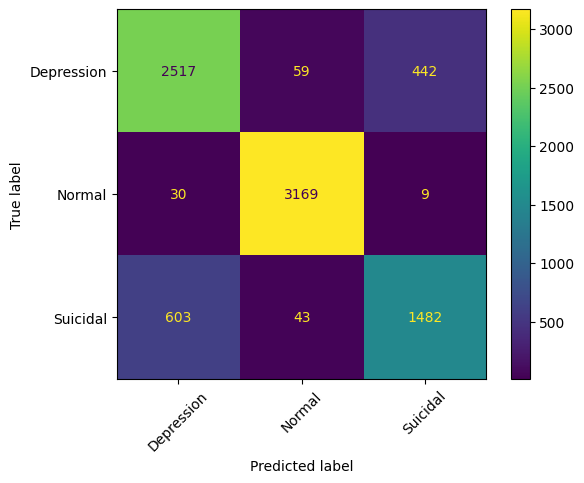

In [15]:
cm = confusion_matrix(y_test, y_pred, labels=sorted(y_test.unique()))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=sorted(y_test.unique())
)
disp.plot(xticks_rotation=45)

In [16]:
if getattr(sa.model.config, "id2label", None):
    id2label = {int(k): v for k, v in sa.model.config.id2label.items()}
    label2id = {v: int(k) for k, v in id2label.items()}
else:
    id2label = dict(sa.id2label)
    label2id = dict(sa.label2id)

class_ids = [k for k in sorted(id2label.keys())]
class_names = [id2label[i] for i in class_ids]

In [ ]:
def predict_proba(texts: list[str], batch_size: int = 32) -> np.ndarray:
    """Return probability matrix shape (n, n_classes) in `class_ids` order."""

    sa.model.eval()

    probs = []

    for start in range(0, len(texts), batch_size):

        batch = texts[start : start + batch_size]

        enc = sa.tokenizer(batch, padding=True, truncation=True, return_tensors="pt")

        enc = {k: v.to(sa.device) for k, v in enc.items()}

        with torch.inference_mode():

            logits = sa.model(**enc).logits

            p = torch.softmax(logits, dim=-1).detach().cpu().numpy()

        probs.append(p)

    return np.vstack(probs)


# --- Explainability (SHAP first, LIME fallback) ---


def _predict_proba_for_explain(texts):

    # shap/lime may pass numpy arrays; normalize to list[str]

    if isinstance(texts, np.ndarray):

        texts = texts.tolist()

    if isinstance(texts, (pd.Series, pd.Index)):

        texts = texts.tolist()

    return predict_proba(list(texts), batch_size=16)


def explain_with_lime(text: str, pred_label: str, num_features: int = 12):
    """Render LIME explanation as a matplotlib chart in the notebook."""

    explainer = LimeTextExplainer(class_names=class_names)

    pred_id = label2id[pred_label]

    exp = explainer.explain_instance(
        text,
        _predict_proba_for_explain,
        labels=[pred_id],
        num_features=num_features,
    )

    fig = exp.as_pyplot_figure(label=pred_id)
    fig.tight_layout()

    # NOTE: `display(fig)` already renders the figure in notebooks;
    # calling `plt.show()` as well can produce a duplicate plot.
    display(fig)
    plt.close(fig)

    return exp

,true,case,pred,confidence,index
0,Depression,worst,Normal,0.999332,3457
1,Depression,best,Depression,0.998745,2973
2,Normal,worst,Depression,0.955526,6960
3,Normal,best,Normal,0.999764,1710
4,Suicidal,worst,Normal,0.999125,3789
5,Suicidal,best,Suicidal,0.950724,1962


## Case Study: Best/Worst Examples per Class

SHAP is preferred (token-level + bar chart). If SHAP fails, LIME will render a matplotlib explanation plot.

### 1/6 — TRUE: `Depression` | CASE: `worst` | PRED: `Normal` | conf=0.999

**Statement:** snapchat layla kuz

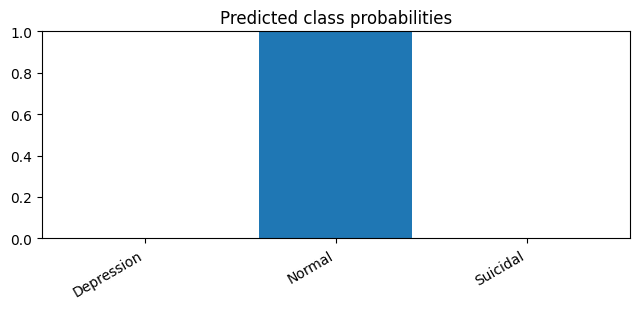

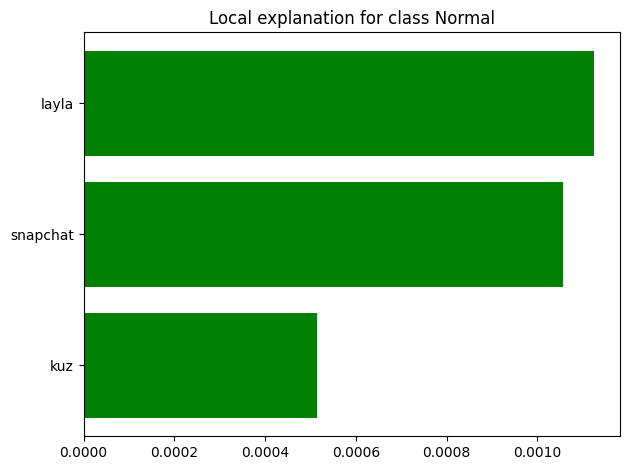

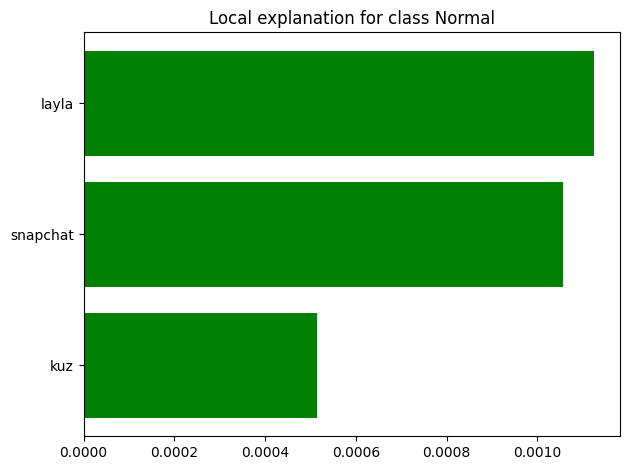

### 2/6 — TRUE: `Depression` | CASE: `best` | PRED: `Depression` | conf=0.999

**Statement:** last november i had a week where i wa so scared of death i couldn t sleep eat drink do anything i have a lot of anxiety and this wa just another one of those thing which bother me every so often but a lot more intense at that point maybe day go by i m so scared i decide to get really high to forget about it not a great idea but nothing go bad day later i start to have really really intense muscle twitching it made my anxiety so bad i had to go go a amp e a i couldn t breathe fast forward month later and i m still twitching every 0 second haven t used any drug in that time until the last week or two i ve noticed it make the twitching way worse when high if i m anxious at all but if i m not anxious the twitching is the same a normal so i m pretty sure it is anxiety related have had blood test done for deficiency s and nothing i also had a test done which told me i m producing time the normal amount of adrenaline constantly pretty sure this is the cause i have no idea what to do and how to stop this and it s driving me insane i m trying to get anxiety med but i have no official anxiety diagnosis so i m not sure if i even can i ve got a doctor appointment earliest they could do is in a month and a half could anyone help me on what to do

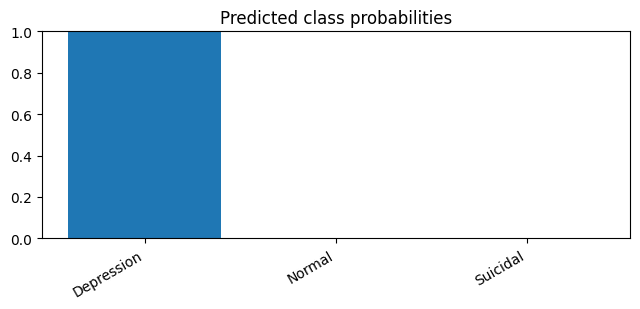

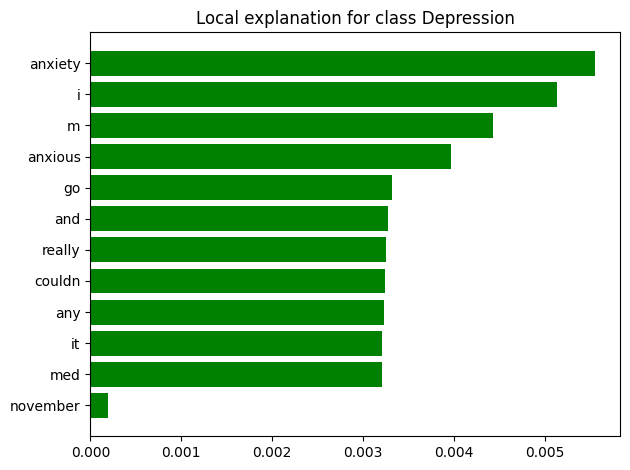

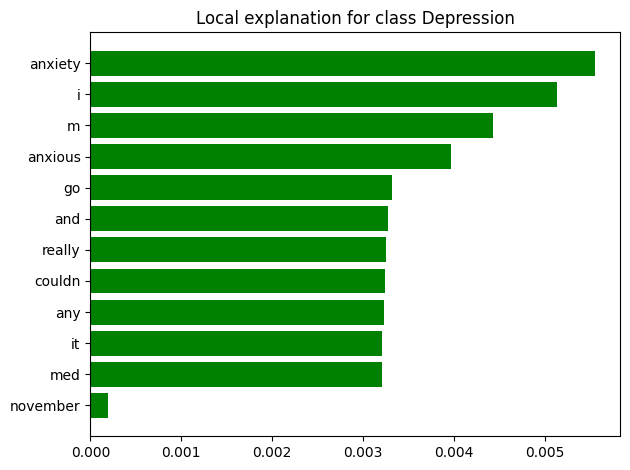

### 3/6 — TRUE: `Normal` | CASE: `worst` | PRED: `Depression` | conf=0.956

**Statement:** i m gon na lay down and count my breath until i fall asleep wooo lol it s cuddle day today i need someone to cuddle with

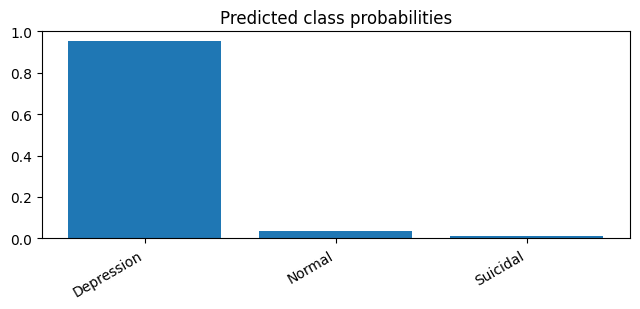

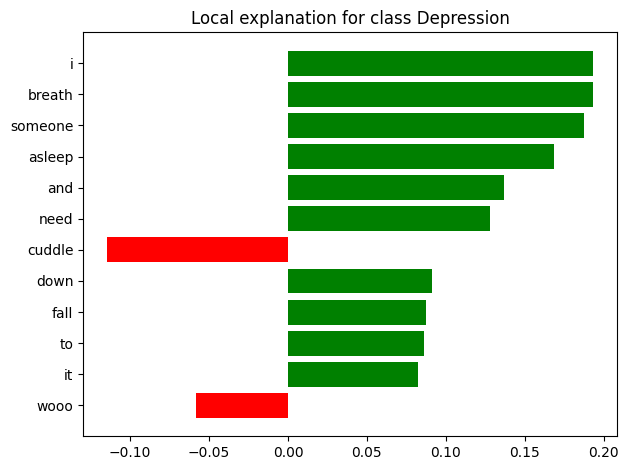

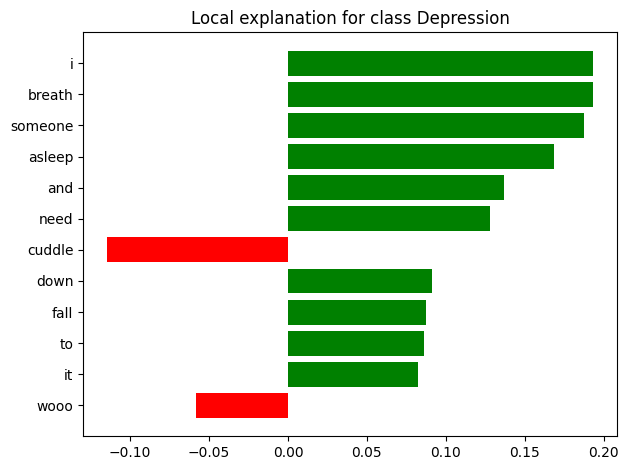

### 4/6 — TRUE: `Normal` | CASE: `best` | PRED: `Normal` | conf=1.000

**Statement:** It's sad when I don't have a dm limit.

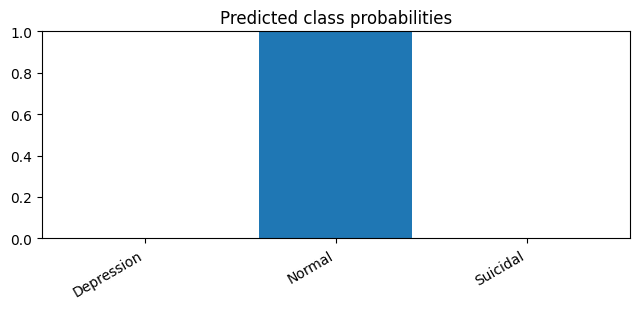

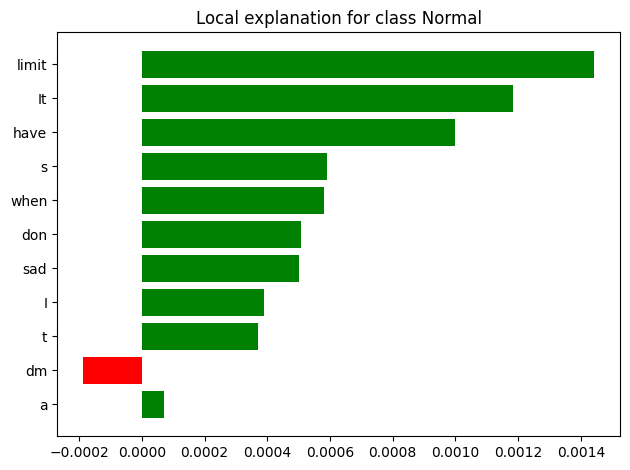

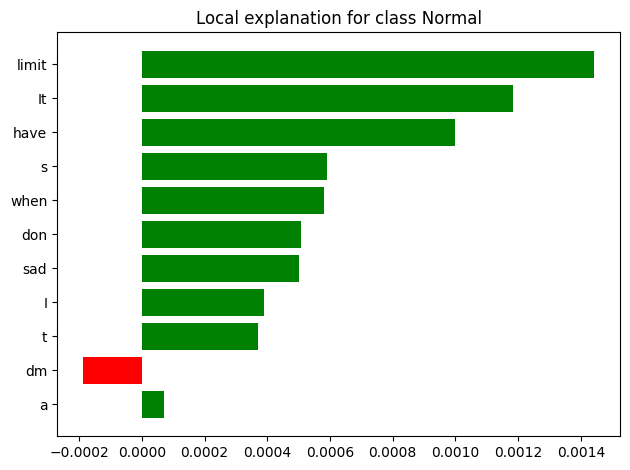

### 5/6 — TRUE: `Suicidal` | CASE: `worst` | PRED: `Normal` | conf=0.999

**Statement:** my wife: on his will it says he's left all his updog to you

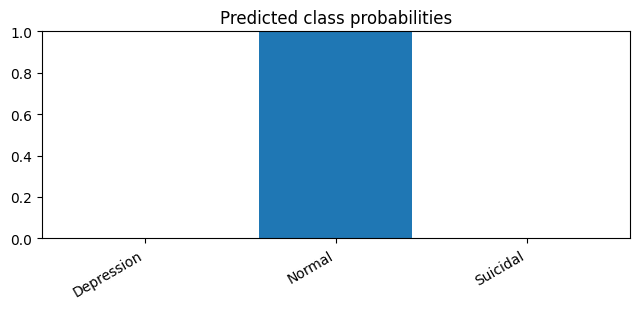

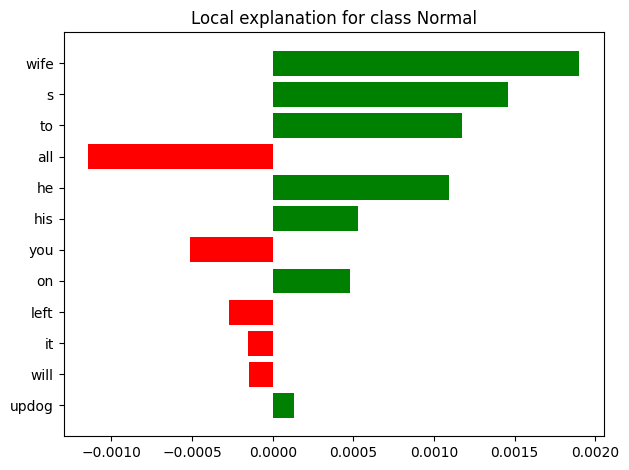

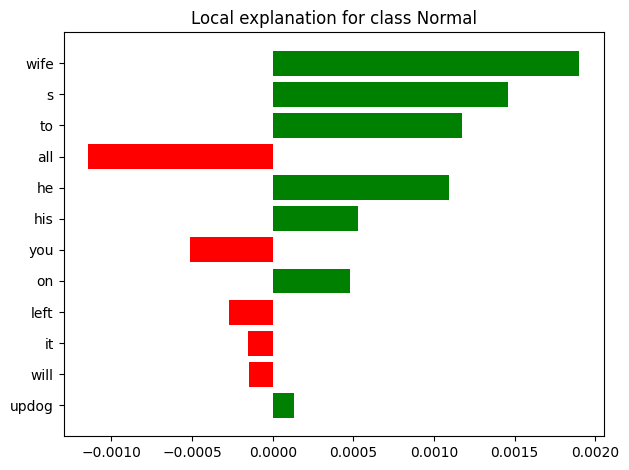

### 6/6 — TRUE: `Suicidal` | CASE: `best` | PRED: `Suicidal` | conf=0.951

**Statement:** RT @palestinianho: patient: i hate myself and i want to die

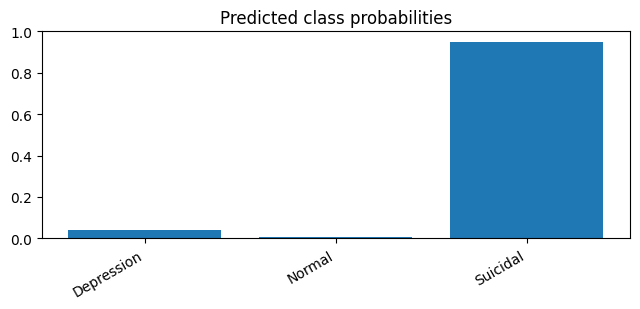

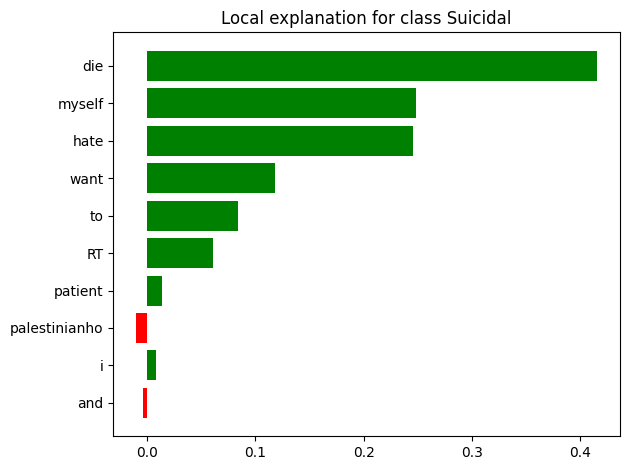

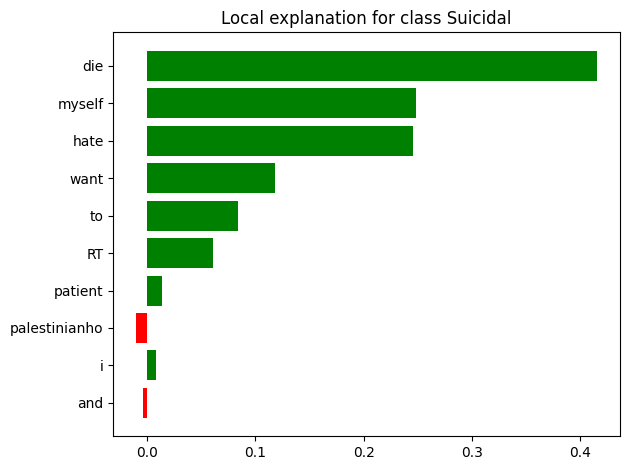

In [18]:
# --- compute probs for test set ---

X_test_list = X_test.tolist()
y_true_list = y_test.tolist()
y_pred_list = list(y_pred)


probs = predict_proba(X_test_list, batch_size=32)
pred_ids = np.array([label2id[p] for p in y_pred_list], dtype=int)
pred_conf = probs[np.arange(len(pred_ids)), pred_ids]


# --- pick best/worst per TRUE class (3 classes -> 6 cases) ---

records = []
unique_classes = list(pd.Series(y_true_list).value_counts().index)

for true_label in unique_classes:
    true_mask = np.array([yt == true_label for yt in y_true_list], dtype=bool)
    correct_mask = true_mask & (np.array(y_pred_list) == true_label)
    wrong_mask = true_mask & (np.array(y_pred_list) != true_label)

    # Best: most confident correct for that class

    if correct_mask.any():
        idxs = np.where(correct_mask)[0]
        cls_id = label2id[true_label]
        cls_conf = probs[idxs, cls_id]
        best_idx = idxs[int(np.argmax(cls_conf))]

        records.append(
            {
                "case": "best",
                "true": true_label,
                "pred": y_pred_list[best_idx],
                "confidence": float(probs[best_idx, cls_id]),
                "statement": X_test_list[best_idx],
                "index": int(best_idx),
            }
        )

    else:
        print(f"No correct examples found for class: {true_label}")

    # Worst: most confidently WRONG (highest confidence in the wrong predicted class)

    if wrong_mask.any():
        idxs = np.where(wrong_mask)[0]
        wrong_conf = pred_conf[idxs]
        worst_idx = idxs[int(np.argmax(wrong_conf))]
        records.append(
            {
                "case": "worst",
                "true": true_label,
                "pred": y_pred_list[worst_idx],
                "confidence": float(pred_conf[worst_idx]),
                "statement": X_test_list[worst_idx],
                "index": int(worst_idx),
            }
        )

    else:

        print(f"No wrong examples found for class: {true_label}")


cases = (
    pd.DataFrame(records)
    .sort_values(["true", "case"], ascending=[True, False])
    .reset_index(drop=True)
)

display(cases[["true", "case", "pred", "confidence", "index"]])

# --- Run explanations for the 6 cases (plots only) ---
display(Markdown("## Case Study: Best/Worst Examples per Class"))
display(
    Markdown(
        "SHAP is preferred (token-level + bar chart). If SHAP fails, LIME will render a matplotlib explanation plot."
    )
)


for i, row in cases.iterrows():

    title = (
        f"### {i+1}/6 — TRUE: `{row['true']}` | CASE: `{row['case']}` | "
        f"PRED: `{row['pred']}` | conf={row['confidence']:.3f}"
    )

    display(Markdown(title))
    display(Markdown(f"**Statement:** {row['statement']}"))

    # Predicted probability distribution (bar chart)
    p = predict_proba([row["statement"]], batch_size=1)[0]

    plt.figure(figsize=(6.5, 3.2))
    plt.bar(class_names, p)
    plt.ylim(0, 1)
    plt.xticks(rotation=30, ha="right")
    plt.title("Predicted class probabilities")
    plt.tight_layout()
    plt.show()

    explain_with_lime(row["statement"], row["pred"], num_features=12)